In [10]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
train_file_path = "DailyDelhiClimateTrain.csv"
test_file_path = "DailyDelhiClimateTest.csv"

# Load the latest train data version
train_df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "sumanthvrao/daily-climate-time-series-data",
  train_file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

# Load the latest test data version
test_df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "sumanthvrao/daily-climate-time-series-data",
  test_file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)


print("First 5 records of Train Data:", train_df.head())
print("\n")
print("First 5 records of Test Data:", test_df.head())

/tmp/ipython-input-3862124310.py:11: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  train_df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'daily-climate-time-series-data' dataset.


/tmp/ipython-input-3862124310.py:22: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  test_df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'daily-climate-time-series-data' dataset.
First 5 records of Train Data:          date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000


First 5 records of Test Data:          date   meantemp   humidity  wind_speed  meanpressure
0  2017-01-01  15.913043  85.869565    2.743478     59.000000
1  2017-01-02  18.500000  77.222222    2.894444   1018.277778
2  2017-01-03  17.111111  81.888889    4.016667   1018.333333
3  2017-01-04  18.700000  70.050000    4.545000   1015.700000
4  2017-01-05  18.388889  74.944444    3.300000   1014.333333


In [3]:
# We need to install the pmdarima library if you don't have it:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 37.2 MB/s eta 0:00:00


# 🚀 Time Series Forecasting with Auto-ARIMA

This document provides an explanation of the **AutoRegressive Integrated Moving Average (Auto-ARIMA)** model, its function, and the advantages it holds over the standard ARIMA model.

---

## 💡 What is Auto-ARIMA?

Auto-ARIMA (typically implemented via the `pmdarima` library) is an **automated approach** to time series modeling. It systematically searches over all combinations of the ARIMA model parameters **($p, d, q$)** to find the optimal set that minimizes a statistical fitness criterion, such as the **Akaike Information Criterion (AIC)**.

### The Core ARIMA(p, d, q) Components

* **p (AutoRegressive Order):** Lagged observations.
* **d (Integrated Order):** The number of differencing steps to achieve stationarity.
* **q (Moving Average Order):** Lagged forecast errors.

---

## 💻 How Auto-ARIMA Works (Referencing the Code)

Auto-ARIMA automates the most time-consuming and subjective part of the modeling process: parameter identification.

### 1. Data Preparation

* **Code:** `series_train = series_train.interpolate(...).fillna(...)`
* **Function:** Before modeling, the time series data must be **cleaned** to remove any `NaN` values (missing data). This step ensures the numerical stability required for the model search and fitting process.

### 2. Parameter Search and Optimization

* **Code:** `auto_model = pm.auto_arima(series_train, start_p=1, max_p=5, ..., stepwise=True)`
* **Function:** Auto-ARIMA conducts a search over the parameter space defined by the `max_p` and `max_q` limits. It often uses the **stepwise algorithm** (`stepwise=True`) for efficiency.
* **Model Selection:** For every model fit, the **AIC** is calculated. The model with the **lowest AIC value** is selected as the **optimal model**. The AIC balances the model's goodness of fit against its complexity.

### 3. Prediction and Evaluation

* **Code (Prediction):** `forecast_array = auto_model.predict(n_periods=n_periods)`
* **Code (Evaluation):** `mse = mean_squared_error(series_test, forecast_series_cleaned)`
* **Function:** The final, best-fit model is used to generate forecasts. The forecast is then compared to the actual test data using metrics like **Root Mean Squared Error (RMSE)** to assess performance.

---

## 🆚 Why Auto-ARIMA is Better than Manual ARIMA

Auto-ARIMA is superior to the traditional approach because it replaces subjective, manual effort with objective, automated statistical optimization.

| Feature | Manual ARIMA | Auto-ARIMA |
| :--- | :--- | :--- |
| **Parameter Selection** | **Manual/Subjective.** Requires visual inspection of **ACF** and **PACF** plots and iterative fitting.  | **Automated/Objective.** Systematically searches the parameter space

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# We need to install the pmdarima library if you don't have it:
# pip install pmdarima
import pmdarima as pm
from sklearn.metrics import mean_squared_error

In [11]:
# --- 2. Preprocessing and Feature Selection ---

# Convert the 'date' column to datetime objects and set as index
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
train_df.set_index('date', inplace=True)
test_df.set_index('date', inplace=True)

# Select the 'meantemp' series
series_train = train_df['meantemp']
series_test = test_df['meantemp']

In [12]:
# --- 3. Robust NaN Handling (Fix for ValueError: Input contains NaN) ---
# Linear interpolation is suitable for continuous data like temperature.
# .fillna(method='bfill') and .fillna(method='ffill') catch any NaNs
# that might be at the very start or end of the series.
print("\nCleaning NaNs using interpolation and filling...")
series_train = series_train.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
series_test = series_test.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

print(f"NaN check on Training Series after cleaning: {series_train.isnull().sum()}")
print(f"NaN check on Test Series after cleaning: {series_test.isnull().sum()}")


Cleaning NaNs using interpolation and filling...
NaN check on Training Series after cleaning: 0
NaN check on Test Series after cleaning: 0


/tmp/ipython-input-370656374.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_train = series_train.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/tmp/ipython-input-370656374.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_test = series_test.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


In [13]:
# --- 4. Use Auto-ARIMA to Find Optimal Order (p, d, q) ---

print("\nRunning Auto-ARIMA to find the optimal model order...")

# Auto-ARIMA automatically determines the optimal (p, d, q) based on AIC
auto_model = pm.auto_arima(
    series_train,
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    m=1,             # Non-seasonal model
    d=None,          # Let auto_arima find optimal differencing (d)
    seasonal=False,
    stepwise=True,   # Use the faster stepwise search
    suppress_warnings=True,
    error_action='ignore'
)

# Print the optimal order
optimal_order = auto_model.order
print("\nOptimal ARIMA Model Found:")
print(auto_model.summary())
print(f"\nOptimal (p, d, q) Order: {optimal_order}")


Running Auto-ARIMA to find the optimal model order...

Optimal ARIMA Model Found:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1462
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2768.239
Date:                Fri, 28 Nov 2025   AIC                           5542.478
Time:                        15:08:33   BIC                           5558.339
Sample:                    01-01-2013   HQIC                          5548.395
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5728      0.046     12.494      0.000       0.483       0.663
ma.L1         -0.8028      0.036    -22.070     

In [14]:
# --- 5. Make Predictions ---

# Use the fitted auto_model to predict the next n_periods values
n_periods = len(series_test)
forecast_array = auto_model.predict(n_periods=n_periods)

# Convert the array back to a pandas Series with the correct index
forecast_series = pd.Series(forecast_array, index=series_test.index)

/tmp/ipython-input-1964149954.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  forecast_series_cleaned = forecast_series_cleaned.fillna(method='ffill').fillna(method='bfill')



Root Mean Squared Error (RMSE) with Auto-ARIMA (1, 1, 1): 10.66


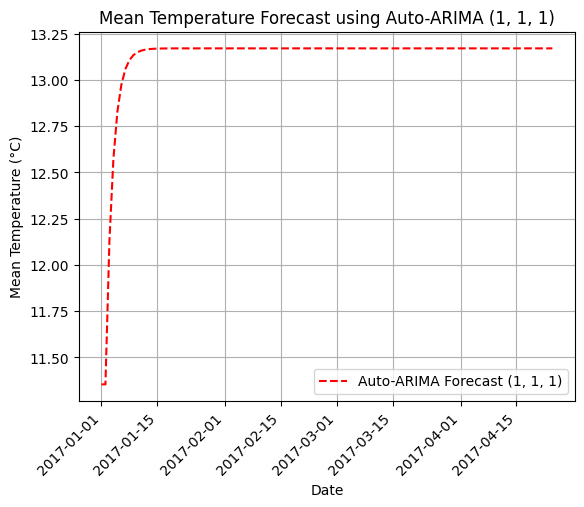

In [17]:
# --- 6. Evaluate and Visualize Results ---

# Explicitly clean the forecast series to handle unexpected NaNs
# We use linear interpolation here, as that is the standard way to fix numerical NaNs in time series output.
# .interpolate() will fill NaNs based on surrounding forecast values.
forecast_series_cleaned = forecast_series.interpolate(method='linear')

# If the NaN is at the very beginning or end (and interpolation can't fill it),
# use forward/backward fill to ensure 100% cleanliness.
forecast_series_cleaned = forecast_series_cleaned.fillna(method='ffill').fillna(method='bfill')

# Now, calculate the metric using the guaranteed clean forecast series
mse = mean_squared_error(series_test, forecast_series_cleaned)
rmse = np.sqrt(mse)

print(f"\nRoot Mean Squared Error (RMSE) with Auto-ARIMA {optimal_order}: {rmse:.2f}")

# ... (Continue with plotting, using forecast_series_cleaned) ...
plt.plot(forecast_series_cleaned.index, forecast_series_cleaned, label=f'Auto-ARIMA Forecast {optimal_order}', color='red', linestyle='--')

plt.title(f'Mean Temperature Forecast using Auto-ARIMA {optimal_order}')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.show()

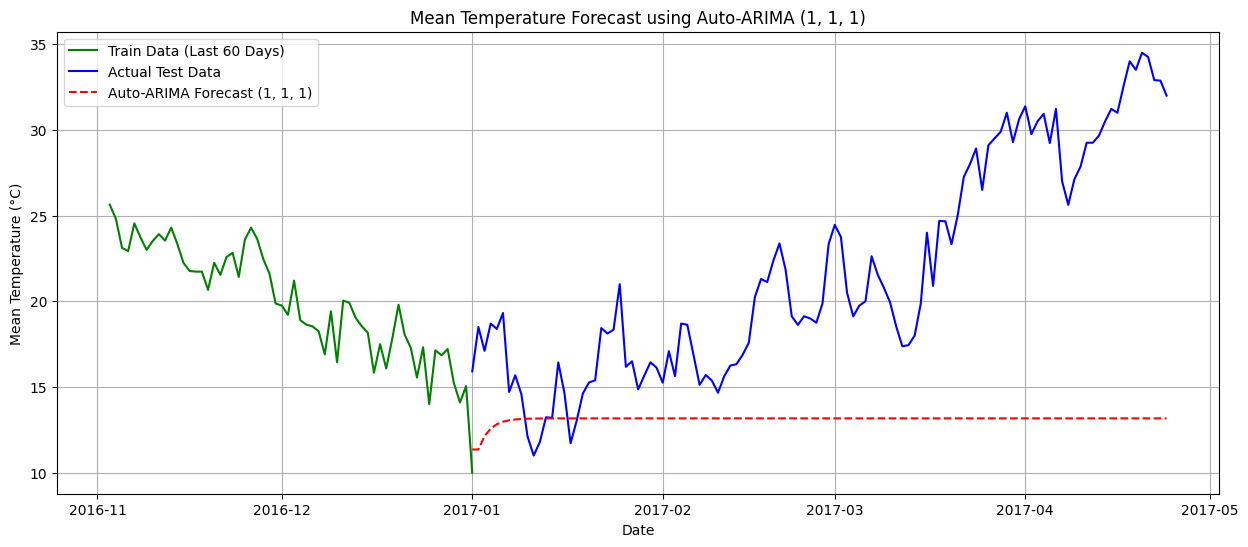

In [18]:
# --- 1. Set up the figure size ---
plt.figure(figsize=(15, 6))

# --- 2. Plot the last part of the training data (e.g., last 60 days) ---
# We use the variable 'series_train' from the Auto-ARIMA script
plt.plot(series_train.index[-60:], series_train[-60:], label='Train Data (Last 60 Days)', color='green')

# --- 3. Plot the actual test data ---
# We use the variable 'series_test'
plt.plot(series_test.index, series_test, label='Actual Test Data', color='blue')

# --- 4. Plot the forecasted values ---
# We use the cleaned forecast series
plt.plot(forecast_series_cleaned.index, forecast_series_cleaned, label=f'Auto-ARIMA Forecast {optimal_order}', color='red', linestyle='--')

# --- 5. Add labels and legend ---
plt.title(f'Mean Temperature Forecast using Auto-ARIMA {optimal_order}')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()